In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
from captum.attr import KernelShap
import cv2

import shap
import numpy as np
from PIL import Image
import time

from model import Generator
from combine_model import AlexNetMNIST, CombinedModel
from shapmap import shap_mapping
from utils import make_image, generate_heatmap, generate_color_heatmap

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
img_path = "test_sample/image/test.jpg"
latent_path = "test_sample/latent_code/test.pth"
sample = torch.load(latent_path)
sample.requires_grad = True

In [4]:
alexnet = AlexNetMNIST()
alexnet.to(device)
model_path = 'mnist_checkpoint/alexnet/mnist_model.pth'
alexnet.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image = Image.open(img_path)
image_np = np.array(image)
image_tensor = transform(image).unsqueeze(0).to(device)

In [6]:
alexnet.eval()
output = alexnet(image_tensor)
target = int(output.argmax().detach().cpu().numpy())
print('Prob', output)

Prob tensor([[ 20.6294, -29.4004, -23.2256, -17.8429, -19.1856, -20.5424,  -5.3435,
         -29.6415, -20.3315,  -8.3095]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [7]:
gan_path = "GAN_checkpoint/pretrained.pt"
g_ema = Generator(32, 256, 8)
g_ema.load_state_dict(torch.load(gan_path)["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.to(device)

In [8]:
combined_model = CombinedModel(g_ema, alexnet, transform)
combined_model = combined_model.to(device)

In [9]:
ks = KernelShap(combined_model)
n_samples = 100
attributions = ks.attribute(sample, target=target, n_samples=n_samples, show_progress=True)

Kernel Shap attribution:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
map = shap_mapping(g_ema, image, sample, input_is_latent=False, threshold=1)
map = map.to(device)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:45<00:00,  3.31s/it]


In [11]:
attributions = attributions.view(256, 1, 1, 1)
attributions[attributions < 0] = 0

fusion_shap = attributions * map
fusion_max = fusion_shap.max()
fusion_min = fusion_shap.min()
fusion_norm = (fusion_shap - fusion_min) / (fusion_max - fusion_min)
Shapley = fusion_norm.mean(dim=0)
img_ar = make_image(Shapley.unsqueeze(0))

In [12]:
backgroud_set = torchvision.datasets.ImageFolder(root="background", transform=transform)
background_loader = torch.utils.data.DataLoader(backgroud_set, batch_size=300,shuffle=True)
classes = backgroud_set.classes

background_dataiter = iter(background_loader)
b_images, b_labels = next(background_dataiter)

b_images = b_images.to((device))
b_labels = b_labels.to((device))

In [13]:
image = Image.open(img_path)
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

alexnet.eval()

e = shap.GradientExplainer(alexnet, b_images)
shap_values = e.shap_values(image)
shap_numpy_g = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

In [14]:
alexnet.eval()
e = shap.DeepExplainer(alexnet, b_images)
shap_values = e.shap_values(image)
shap_numpy_d = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
target_label = target
gradient_shap = shap_numpy_g[target_label][0]
gradient_shap = np.sum(gradient_shap, axis=2)
gradient_shap = np.maximum(gradient_shap, 0)
gradient_shap = cv2.resize(gradient_shap, (28, 28))

deep_shap = shap_numpy_d[target_label][0]
deep_shap = np.sum(deep_shap, axis=2)
deep_shap = np.maximum(deep_shap, 0)
deep_shap = cv2.resize(deep_shap, (28, 28))

latent_shap = img_ar[0, :, :, :]
latent_shap = np.mean(latent_shap, 2)
latent_shap = np.maximum(latent_shap, 0)
latent_shap = cv2.resize(latent_shap, (28, 28))

(-0.5, 27.5, 27.5, -0.5)

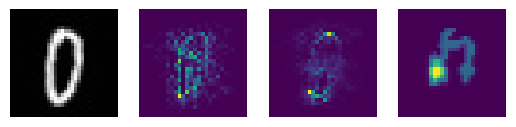

In [16]:
plt.subplot(1, 4, 1)
plt.imshow(image_np)
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(gradient_shap)
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(deep_shap)
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(latent_shap)
plt.axis('off')